# vote_coefficients_0x421510312C40486965767be5Ea603Aa8a5707983_2


In [62]:
import os
from pathlib import Path
import numpy as np

import pandas as pd

from sbdata.FlipsideApi import FlipsideApi

# Set path to data folder
current_dir = Path(os.getcwd())
PATH_TO_EXPORT = os.path.join(current_dir.parent.parent, 'tx_data', 'all_beta_rounds')
DATA_DIR = os.path.join(current_dir.parent.parent, 'data-regen-rangers')
DATA_DIR_GITCOIN = os.path.join(current_dir.parent.parent, 'data-gitcoin')
CSV_GITCOIN_GRANTS = 'vote_coefficients_0x421510312C40486965767be5Ea603Aa8a5707983_2.csv'

# read the address from oss grant

api_key = os.environ['FLIPSIDE_API_KEY']
flipside_api = FlipsideApi(api_key, max_address=400)
PATH_TO_VOTES = os.path.join(DATA_DIR, "votes_baoki.csv")
PATH_TO_GRANTS = os.path.join(DATA_DIR, "all-allo-rounds.csv")
PATH_TO_PROJECTS = os.path.join(DATA_DIR, "projects_QmQurt.csv")
PATH_TO_VOTES_GITCOIN = os.path.join(DATA_DIR_GITCOIN, CSV_GITCOIN_GRANTS)

# load data
df_votes = pd.read_csv(PATH_TO_VOTES_GITCOIN)
df_grants = pd.read_csv(PATH_TO_GRANTS)
df_application = pd.read_csv(PATH_TO_PROJECTS)
# Lowercase all addresses because flipside api return lowercase address
#id,projectId,applicationId,roundId,token,voter,grantAddress,amount,amountUSD,coefficient,status,last_score_timestamp,type,success,rawScore,threshold
df_grants['Round ID'] = df_grants['Round ID'].str.lower()
str_columns_votes = ['id', 'projectId', 'roundId', 'voter', 'grantAddress']
df_votes[str_columns_votes] = df_votes[str_columns_votes].applymap(lambda x: x.lower())

str_columns_application = ['id', 'roundId', 'metadata.application.round', 'metadata.application.recipient']
df_application[str_columns_application] = df_application[str_columns_application].applymap(lambda x: str(x).lower())

# round_id = df_grants[df_grants['Round name'] == 'Web3 Community and Education']['Round ID'].values[0]
array_unique_address = df_votes['voter'].unique()

array_unique_address = np.char.lower(array_unique_address.astype(str))


In [63]:
df_votes.shape

(1970, 16)

In [64]:
from sbutils import LoadData

# Load data
data_loader = LoadData.LoadData(PATH_TO_EXPORT)
df_tx = data_loader.create_df_tx('ethereum', array_unique_address)

In [65]:
len(array_unique_address)

495

In [66]:
df_tx.EOA.nunique()

495

In [67]:
c = np.setxor1d(array_unique_address, df_tx.EOA.values)
c

array([], dtype=object)

## Computing legos booleans

In [68]:
from sblegos.TransactionAnalyser import TransactionAnalyser as txa
tx_analyser = txa(df_tx, df_address=pd.DataFrame(np.intersect1d(df_tx.EOA.unique(), array_unique_address)))

use matching address because some addresses are not in the extracted data set

In [69]:
df_matching_address = pd.DataFrame(df_tx.EOA.unique(), columns=["address"])
df_matching_address.head(2)

,address
0,0x0110e6917a7bc72afef832989295d5f9ff539bb1
1,0x0117780bdaf2a9ea19ed897ab7db710452a7c00f


Compute the boolean 

less than 10 x transaction are not performant legos so we don't use it, has same seed is computed as an intermediarry to get the seed_suspicious flag

In [70]:
df_matching_address['seed_same_naive'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_same_seed_naive(x))
df_matching_address['seed_same'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_same_seed(x))
df_matching_address['seed_suspicious'] = df_matching_address.loc[:, 'seed_same_naive'].ne(df_matching_address.loc[:, 'seed_same'])
df_matching_address['less_5_tx'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_less_than_n_transactions(x, 5))
# df_matching_address['less_10_tx'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_less_than_n_transactions(x, 10))
df_matching_address['interacted_other_ctbt'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_interacted_with_other_contributor(x))

In [71]:
print(f'Number of voters: {len(df_matching_address)}')

Number of voters: 495


In [72]:
df_matching_address.sum()

address                  0x0110e6917a7bc72afef832989295d5f9ff539bb10x01...
seed_same_naive                                                        256
seed_same                                                              266
seed_suspicious                                                         12
less_5_tx                                                               69
interacted_other_ctbt                                                  128
dtype: object

### Investigating the boolean seed suspicious

In [73]:
df_matching_address[df_matching_address['seed_suspicious'] == True]

,address,seed_same_naive,seed_same,seed_suspicious,less_5_tx,interacted_other_ctbt
81,0x33b15ac83ddb2d13ead0e90834630007108b0f5c,False,True,True,False,False
122,0x48b6db5bc3bcb1d29d3cdd95e97478dee74c992a,False,True,True,False,False
148,0x5a38085a8fdc96da4bea187c3dfe7963cb6f1b36,False,True,True,False,True
212,0x7493b0e130de151226f165395e17093cf87e6c0b,False,True,True,False,False
252,0x88dbfc20d2f2bc004d4dde1947deda4cd478dd0d,False,True,True,False,False
262,0x8e22a4c2901da99777d76f80f29640fc81ae96bb,False,True,True,False,False
312,0xa68168514efb41ff40c410f35bde87ff7665730b,False,True,True,False,False
315,0xa7ca400d49bba87eb606ee05af93689bd21fab99,False,True,True,False,True
412,0xd48339d2d8da11a8f16ef696f0a42f495177fbf9,False,True,True,False,False
429,0xdb9b58a23cbac3e21b3a0516c40958104e3f7119,False,True,True,False,False


In [74]:
# projects_voted = df_votes[df_votes['voter'] == '0xc28064b875ae25f9a2ca28c08f116a5c26229f69']
# print(f'Number of votes {projects_voted.shape[0]} Number of projects voted: {projects_voted.grantAddress.nunique()}')
# # Merge the project the user voted for and the projects 
# projects_voted.merge(df_application, left_on='grantAddress', right_on='metadata.application.recipient', how='left').drop_duplicates(subset='grantAddress').loc[:, ['grantAddress', 'metadata.application.project.title', 'status', 'metadata.application.round']].reset_index(drop=True)

Some of the projects he donated to are in the list of Rejected projects showing that this address is indeed a sybil. And may have contributed to ohter fraudulent projects.

- Pulsar is not very active and is forked code for the most part
- Fusion not very active on github but has a lot of activity on twitter 
- Share suspicious Github with no activity, twitter does not exists: suspicious

Other projects are ok

In [75]:
# projects_voted = df_votes[df_votes['voter'] == '0x61ffe691821291d02e9ba5d33098adcee71a3a17']
# print(f'Number of votes {projects_voted.shape[0]} Number of projects voted: {projects_voted.grantAddress.nunique()}')
# # Merge the project the user voted for and the projects 
# projects_voted.merge(df_application, left_on='grantAddress', right_on='metadata.application.recipient', how='left').drop_duplicates(subset='grantAddress').loc[:, ['grantAddress', 'metadata.application.project.title']].reset_index(drop=True)

In [76]:
# projects_voted = df_votes[df_votes['voter'] == '0xe51200a4d161935fc311ed8a0401feb1abf20e3a']
# print(f'Number of votes {projects_voted.shape[0]} Number of projects voted: {projects_voted.grantAddress.nunique()}')
# # Merge the project the user voted for and the projects 
# projects_voted.merge(df_application, left_on='grantAddress', right_on='metadata.application.recipient', how='left').drop_duplicates(subset='grantAddress').loc[:, ['grantAddress', 'metadata.application.project.title']].reset_index(drop=True)

The boolean seed suspicious is not relevant for that round we will not use it for the analysis.

### Computing the new dex interaction score
It was investigated in another notebook 

In [77]:
def get_interacted_address(from_address, to_address, address):
    if from_address == address:
        return to_address
    else:
        return from_address

def count_interaction_with_any(tx_analyser, address, array_address):
    """
    Return an integer of the number of interactions with the addresses in the array_address
    Parameters
    ----------
    address : str
        The address to check

    Returns
    -------
    count_interaction_with_any : int
        The number of interactions with the addresses in the array_address
    """
    tx_analyser.set_group_by_sorted_EOA()

    df = tx_analyser.gb_EOA_sorted.get_group(address)
    address_interacted = df.apply(lambda x: get_interacted_address(x['from_address'], x['to_address'], address), axis=1)
    tx_boolean_interacted = address_interacted.isin(array_address)
    return tx_boolean_interacted.sum()

def has_interacted_with_any(tx_analyser, address, array_address):
    """
    Return a boolean whether the address has interacted with any address in the array_address
    Parameters
    ----------
    address : str
        The address to check

    Returns
    -------
    has_interacted_with_any : bool
        True if the address has interacted with one or more of the addresses in the array_address
    """
    count_interaction_with_any = count_interaction_with_any(tx_analyser, address, array_address)
    return count_interaction_with_any > 0

In [78]:
label_query = '''
SELECT ADDRESS, CREATOR, LABEL_TYPE, ADDRESS_NAME, PROJECT_NAME
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
AND LABEL_SUBTYPE = 'pool' 
;'''
df_label = flipside_api.execute_query(label_query)

In [79]:
# extract all the pool addresses
array_pool_address = df_label['address'].unique()

In [80]:
tx_analyser.set_group_by_sorted_EOA()

In [81]:
# Compute the number of interactions with any of the pools for each address
df_matching_address['count_interaction_with_pool'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, array_pool_address))

In [82]:
(df_matching_address['count_interaction_with_pool'] > 0).sum() / len(df_matching_address)

0.24646464646464647

In [83]:
label_query = '''
SELECT DISTINCT(LABEL_SUBTYPE)
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
;'''
df_distinct_labels = flipside_api.execute_query(label_query)

In [84]:
df_distinct_labels.label_subtype.unique()

array(['chadmin', 'router', 'multisig', 'airdrop_contract',
       'deposit_wallet', 'staking_contract', 'marketplace', 'foundation',
       'bridge', 'token_contract', 'mint_burn', 'mint_contract',
       'contract_deployer', 'nf_token_contract', 'token_distribution',
       'nf_position_manager', 'governance', 'pool', 'vault',
       'general_contract', 'mining_pool', 'donation_address',
       'fee_wallet', 'cold_wallet', 'escrow', 'reserve', 'swap_router',
       'hot_wallet', 'strategy', 'dao', 'rewards', 'voting', 'toxic',
       'distributor_cex', 'swap_contract', 'treasury', 'token_sale',
       'oracle', 'aggregator_contract'], dtype=object)

From these tags lets flag any address that have interacted with a toxic wallet

In [85]:
label_query = '''
SELECT ADDRESS, CREATOR, LABEL_TYPE, ADDRESS_NAME, PROJECT_NAME
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
AND LABEL_SUBTYPE = 'toxic'
;'''
df_toxic = flipside_api.execute_query(label_query)

In [86]:
df_toxic.shape

(4857, 6)

In [87]:
# Compute the number of interactions with any of the scam for each address
df_matching_address['count_interaction_with_toxic'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_toxic['address'].unique()))

In [88]:
print(f'Percentage of addresses that have interacted with a toxic address: {int((df_matching_address["count_interaction_with_toxic"] > 0).sum() / len(df_matching_address) *100)}%')

Percentage of addresses that have interacted with a toxic address: 1%


In [89]:
tag_query = '''
SELECT DISTINCT(TAG_TYPE)
FROM crosschain.core.address_tags 
WHERE BLOCKCHAIN='ethereum'
;'''
df_distinct_tags = flipside_api.execute_query(tag_query)

In [90]:
df_distinct_tags.tag_type.values

array(['contract', 'Aave Delegates', 'dex', 'chainlink oracle', 'NFT',
       'cex', 'dydx delegate', 'nft', 'Balancer Delegates', 'activity',
       'wallet'], dtype=object)

I found the tag_name "airdrop master" could be interesting 

In [91]:
query_airdrop_master = '''
SELECT BLOCKCHAIN, CREATOR, ADDRESS, TAG_NAME
FROM crosschain.core.address_tags 
WHERE BLOCKCHAIN='ethereum'
AND TAG_NAME = 'airdrop master'
;
'''
df_airdrop_master = flipside_api.execute_query(query_airdrop_master)

In [92]:
# Compute the number of interactions with any of the aidrop for each address
df_matching_address['count_interaction_with_airdrop_m'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_airdrop_master['address'].unique()))
print(f'Percentage of addresses that interacted with airdrop master: {int((df_matching_address["count_interaction_with_airdrop_m"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with airdrop master: 15%


In [93]:
# Boolean whether the address is a aidrop master
df_matching_address['is_airdrop_master'] = df_matching_address['address'].apply(lambda x: x in df_airdrop_master['address'].unique()) 
print(f'Percentage of addresses that are airdrop master: {int((df_matching_address["is_airdrop_master"]).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that are airdrop master: 5%


In [94]:
sql_query_tornado = '''
SELECT DISTINCT PROJECT_NAME, ADDRESS
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='ethereum'
AND PROJECT_NAME LIKE '%tornado%'
;
'''
df_tornado = flipside_api.execute_query(sql_query_tornado)

In [95]:
# Count the number of interactions with tornado
df_matching_address['count_interaction_with_tornado'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_tornado['address'].unique()))
print(f'Percentage of addresses that interacted with tornado: {int((df_matching_address["count_interaction_with_tornado"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with tornado: 2%


In [96]:
# Count the number of time the address interatec with disperse contract: '0xD152f549545093347A162Dce210e7293f1452150'
df_matching_address['count_interaction_with_disperse'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, [str.lower('0xD152f549545093347A162Dce210e7293f1452150')]))
print(f'Percentage of addresses that interacted with disperse: {int((df_matching_address["count_interaction_with_disperse"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with disperse: 1%


In [97]:
df_matching_address.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

,count_interaction_with_pool,count_interaction_with_toxic,count_interaction_with_airdrop_m,count_interaction_with_tornado,count_interaction_with_disperse
count,495.000000,495.000000,495.000000,495.000000,495.000000
mean,5.642424,0.014141,1.616162,0.092929,0.010101
std,37.936867,0.134232,8.152031,0.932678,0.100096
min,0.000000,0.000000,0.000000,0.000000,0.000000
10%,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
90%,7.000000,0.000000,1.600000,0.000000,0.000000
max,745.000000,2.000000,96.000000,14.000000,1.000000


In [98]:
df_matching_address['has_interaction_toxic'] = df_matching_address['count_interaction_with_toxic'] > 0
df_matching_address['has_no_pool_interaction'] = df_matching_address['count_interaction_with_pool'] < 6
df_matching_address['has_interaction_airdrop_m'] = df_matching_address['count_interaction_with_airdrop_m'] > 0
df_matching_address['has_interaction_tornado'] = df_matching_address['count_interaction_with_tornado'] > 0
df_matching_address['has_interaction_disperse'] = df_matching_address['count_interaction_with_disperse'] > 0

In [99]:
boolean_features = ['seed_suspicious', 'has_interaction_toxic', 'has_no_pool_interaction', 'has_interaction_airdrop_m', 'has_interaction_tornado', 'has_interaction_disperse', 'is_airdrop_master', 'interacted_other_ctbt']

In [100]:
df_matching_address[boolean_features].sum() 

seed_suspicious               12
has_interaction_toxic          6
has_no_pool_interaction      435
has_interaction_airdrop_m     75
has_interaction_tornado       10
has_interaction_disperse       5
is_airdrop_master             26
interacted_other_ctbt        128
dtype: int64

In [101]:
len(df_matching_address)

495

In [102]:
(df_matching_address[boolean_features].sum(axis=1) > 2).sum()

37

In [103]:
df_matching_address['count_flags'] = df_matching_address[boolean_features].sum(axis=1)

In [104]:
df_matching_address['suspicious_1'] = df_matching_address['count_flags'] > 2

In [105]:
df_suspicious_1 = df_matching_address[df_matching_address['suspicious_1'] == True]

### Investigating the grants receiving the most votes from the flagged addresses

In [106]:
df_vote_sus1 = df_votes[df_votes['voter'].isin(df_suspicious_1['address'])]
count_unique_vote_grant = df_votes.drop_duplicates(subset=['grantAddress', 'voter']).groupby('grantAddress')['id'].count().sort_values(ascending=False).reset_index()
count_suspicious_vote_grant = df_vote_sus1['grantAddress'].value_counts().reset_index()
df_vote_grant = count_unique_vote_grant.merge(count_suspicious_vote_grant, left_on='grantAddress', right_on='grantAddress', how='left').fillna(0).rename(columns={'id': 'count_unique_vote', 'count': 'count_suspicious_vote'})

In [107]:
df_votes.shape

(1970, 16)

In [108]:
df_vote_grant['percentage_suspicious_vote'] = df_vote_grant['count_suspicious_vote'] / df_vote_grant['count_unique_vote'] * 100
print(f'Number of suspicious votes {df_vote_sus1.shape[0]} Number of projects voted: {df_vote_sus1.grantAddress.nunique()}')
# Merge the project the user voted for and the projects 
gr_sus = df_vote_grant.merge(df_application, left_on='grantAddress', right_on='metadata.application.recipient', how='left').drop_duplicates(subset='grantAddress').loc[:, ['grantAddress', 'metadata.application.project.title', 'percentage_suspicious_vote', 'count_suspicious_vote', 'roundId', 'status']].reset_index(drop=True).sort_values(by='percentage_suspicious_vote', ascending=False)
print(f'number of grants: {gr_sus.shape[0]}')
gr_sus.head(30)

Number of suspicious votes 351 Number of projects voted: 104
number of grants: 104


,grantAddress,metadata.application.project.title,percentage_suspicious_vote,count_suspicious_vote,roundId,status
91,0x09baddebf74a112a00950cae90b61650de4dbcdb,regrò,71.428571,5,0x421510312c40486965767be5ea603aa8a5707983,APPROVED
93,0xc9683e50d2edc15c72b7a7bb8666f7c5c466fe19,CCC: photojournalism expeditions on the field ...,57.142857,4,0x421510312c40486965767be5ea603aa8a5707983,APPROVED
61,0x82d4f37d3a5ebf9b7d89e9d83e1fc59dad3e97af,Ranna: Filmmakers for Climate,54.545455,6,0x421510312c40486965767be5ea603aa8a5707983,APPROVED
87,0xd3f0f07e1c4068b9e80fd641599324f5a768f10b,Fundación Tucultura,50.000000,4,0x421510312c40486965767be5ea603aa8a5707983,APPROVED
66,0xe6ff2e03bb419e91d67bb537fcda9ade555ded88,MesoReefDAO - Regenerating Reef Conservation w...,45.454545,5,0x421510312c40486965767be5ea603aa8a5707983,APPROVED
79,0x423f505479a50264f14730bb8ffcdee67da11d56,Biolumen,44.444444,4,0x421510312c40486965767be5ea603aa8a5707983,APPROVED
99,0xf263c33faa2e900ff036b3904082af96af8afbf7,Empathia,40.000000,2,0x421510312c40486965767be5ea603aa8a5707983,APPROVED
102,0xcc9cd175c0f053b8f97cf479280afd0b30e1df30,Regeneratie Coöperatie,40.000000,2,0x421510312c40486965767be5ea603aa8a5707983,APPROVED
85,0xc705bfefc772b2b0b1cf1652ca3b71e2c933f5c5,ECOHUELLAS,37.500000,3,0x421510312c40486965767be5ea603aa8a5707983,APPROVED
40,0x16d46098e455a04cf7f3e43c3b2706614fdbec85,Myseelia 🍄,37.500000,6,0x421510312c40486965767be5ea603aa8a5707983,APPROVED


### Look at the addresses with at least one flag

We are going to review the addresses that have at least 1 flag:
- has_intercation_toxic 
- has_interaction_disperse
- has_interaction_airdrop_master
- is airdrop master
- seed suspicious
- interacted with other contributor and less than 5 tx

I decided to remove tornado cash because someone can be anonimous with out being a sybil

In [109]:
df_matching_address['interact_less_5tx'] = np.logical_and(df_matching_address['interacted_other_ctbt'], df_matching_address['less_5_tx'])

In [110]:
interaction_bool = ['has_interaction_toxic', 'has_interaction_airdrop_m', 'has_interaction_disperse', 'is_airdrop_master', 'seed_suspicious', 'interact_less_5tx']

In [111]:
df_matching_address[interaction_bool].sum()

has_interaction_toxic         6
has_interaction_airdrop_m    75
has_interaction_disperse      5
is_airdrop_master            26
seed_suspicious              12
interact_less_5tx            13
dtype: int64

In [112]:
from scipy.spatial.distance import pdist

def jaccard_similarity_matrix(df):
    
    n = df.shape[1]
    scores = 1 - pdist(np.array(df).T, metric='jaccard')
    result = np.zeros((n,n))
    result[np.triu_indices(n, k=1)] = scores
    result += result.T
    np.fill_diagonal(result, 1)
    return pd.DataFrame(result, index=df.columns, columns=df.columns)

jaccard_similarity = jaccard_similarity_matrix(df_matching_address[interaction_bool])
jaccard_similarity

,has_interaction_toxic,has_interaction_airdrop_m,has_interaction_disperse,is_airdrop_master,seed_suspicious,interact_less_5tx
has_interaction_toxic,1.000000,0.051948,0.100000,0.066667,0.058824,0.0
has_interaction_airdrop_m,0.051948,1.000000,0.025641,0.311688,0.023529,0.0
has_interaction_disperse,0.100000,0.025641,1.000000,0.033333,0.000000,0.0
is_airdrop_master,0.066667,0.311688,0.033333,1.000000,0.000000,0.0
seed_suspicious,0.058824,0.023529,0.000000,0.000000,1.000000,0.0
interact_less_5tx,0.000000,0.000000,0.000000,0.000000,0.000000,1.0


<Axes: >

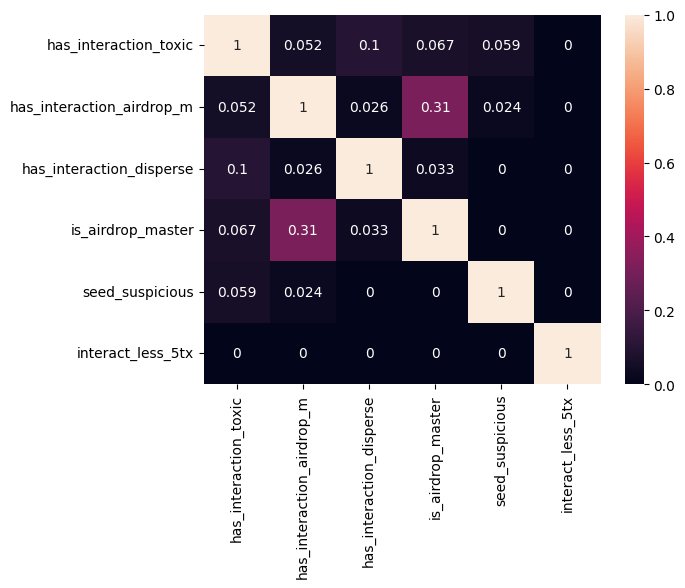

In [113]:
import seaborn as sns
sns.heatmap(jaccard_similarity, annot=True)

In [114]:
df_matching_address['flagged'] = df_matching_address[interaction_bool].sum(axis=1) > 0
df_interact_sus_2 = df_matching_address[df_matching_address['flagged'] == True]
print(f'Number of addresses that interacted with a suspicious contract or address: {df_interact_sus_2.shape[0]}')

Number of addresses that interacted with a suspicious contract or address: 104


In [115]:
df_vote_sus_2 = df_votes[df_votes['voter'].isin(df_interact_sus_2['address'])]
# count_unique_vote_grant = df_votes.drop_duplicates(subset=['grantAddress', 'voter']).groupby('grantAddress')['id'].count().sort_values(ascending=False).reset_index().head(10)
count_suspicious_vote_grant_2 = df_vote_sus_2['grantAddress'].value_counts().reset_index()
df_vote_grant_2 = count_unique_vote_grant.merge(count_suspicious_vote_grant_2, left_on='grantAddress', right_on='grantAddress', how='left').fillna(0).rename(columns={'id': 'count_unique_vote', 'count': 'count_suspicious_vote'})

In [116]:
df_votes.shape

(1970, 16)

In [117]:
df_vote_grant_2['percentage_suspicious_vote'] = df_vote_grant_2['count_suspicious_vote'] / df_vote_grant_2['count_unique_vote'] * 100
print(f'Number of suspicious votes {df_vote_sus_2.shape[0]} Number of projects voted: {df_vote_sus_2.grantAddress.nunique()}')
# Merge the project the user voted for and the projects 
gr_sus_2 = df_vote_grant_2.merge(df_application, left_on='grantAddress', right_on='metadata.application.recipient', how='left').drop_duplicates(subset='grantAddress').loc[:, ['grantAddress', 'metadata.application.project.title', 'percentage_suspicious_vote', 'count_suspicious_vote', 'roundId', 'status']].reset_index(drop=True).sort_values(by='percentage_suspicious_vote', ascending=False)
print(f'number of grants: {gr_sus.shape[0]}')
gr_sus_2.head(30)

Number of suspicious votes 531 Number of projects voted: 104
number of grants: 104


,grantAddress,metadata.application.project.title,percentage_suspicious_vote,count_suspicious_vote,roundId,status
91,0x09baddebf74a112a00950cae90b61650de4dbcdb,regrò,71.428571,5,0x421510312c40486965767be5ea603aa8a5707983,APPROVED
87,0xd3f0f07e1c4068b9e80fd641599324f5a768f10b,Fundación Tucultura,62.500000,5,0x421510312c40486965767be5ea603aa8a5707983,APPROVED
99,0xf263c33faa2e900ff036b3904082af96af8afbf7,Empathia,60.000000,3,0x421510312c40486965767be5ea603aa8a5707983,APPROVED
100,0xa9dad55fd684f252d5fdb240e8f8fc57f1ddfae6,libpwrm,60.000000,3,0x421510312c40486965767be5ea603aa8a5707983,APPROVED
93,0xc9683e50d2edc15c72b7a7bb8666f7c5c466fe19,CCC: photojournalism expeditions on the field ...,57.142857,4,0x421510312c40486965767be5ea603aa8a5707983,APPROVED
40,0x16d46098e455a04cf7f3e43c3b2706614fdbec85,Myseelia 🍄,56.250000,9,0x421510312c40486965767be5ea603aa8a5707983,APPROVED
79,0x423f505479a50264f14730bb8ffcdee67da11d56,Biolumen,55.555556,5,0x421510312c40486965767be5ea603aa8a5707983,APPROVED
78,0x3fa2284d9320badd6c1c1200faacffa0ab54b669,Proof of Zero,55.555556,5,0x421510312c40486965767be5ea603aa8a5707983,APPROVED
61,0x82d4f37d3a5ebf9b7d89e9d83e1fc59dad3e97af,Ranna: Filmmakers for Climate,54.545455,6,0x421510312c40486965767be5ea603aa8a5707983,APPROVED
54,0x949bba9f1c13f2461835366aebcb53c852dd4308,Younergy Crypto,50.000000,6,0x421510312c40486965767be5ea603aa8a5707983,APPROVED


In [118]:
boolean_to_keep = ['seed_suspicious', 'has_interaction_toxic', 'has_no_pool_interaction', 'has_interaction_tornado', 'has_interaction_disperse', 'is_airdrop_master', 'has_interaction_airdrop_m', 'interacted_other_ctbt', 'interact_less_5tx', 'flagged']

In [119]:
df_matching_address[boolean_to_keep].sum()

seed_suspicious               12
has_interaction_toxic          6
has_no_pool_interaction      435
has_interaction_tornado       10
has_interaction_disperse       5
is_airdrop_master             26
has_interaction_airdrop_m     75
interacted_other_ctbt        128
interact_less_5tx             13
flagged                      104
dtype: int64

In [120]:
df_votes.shape

(1970, 16)

In [121]:
final_merge = df_votes.merge(df_matching_address[boolean_to_keep + ['address']], left_on='voter', right_on='address', how='left')
print(f'number of squelched votes out of {final_merge.shape[0]}')
final_merge.shape[0] - final_merge[['coefficient']].sum() 

number of squelched votes out of 1970


coefficient    330
dtype: int64

In [122]:
print(df_votes.shape)
print(final_merge.shape)

(1970, 16)
(1970, 27)


C:\Users\DELL Admin\AppData\Local\Temp\ipykernel_8948\2681738413.py:7: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_votes_stephi = pd.read_csv(os.path.join(DATA_DIR_STEFI, CSV_STEPHI))


(81811, 19) votes stephi
(1970, 27) final merge
(1970, 29) votes merge


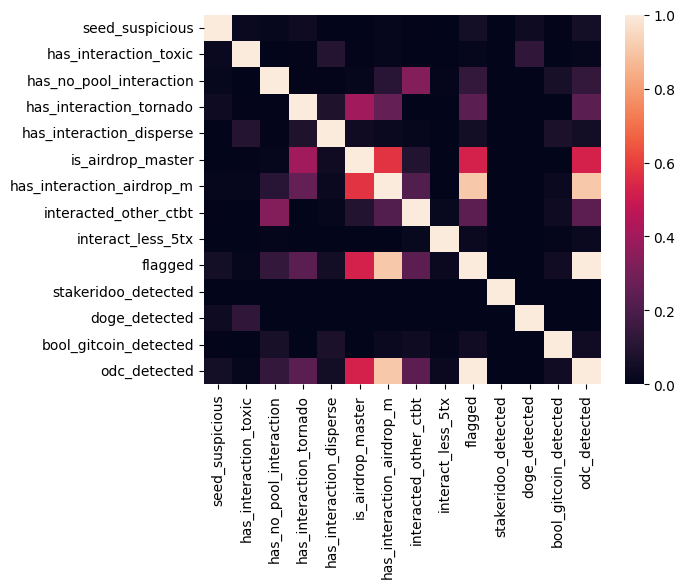

In [127]:
# Adding Stakeriddo and Gray flagged wallet

DATA_DIR_STEFI = os.path.join(current_dir.parent.parent, 'stefi')
CSV_STEPHI = 'sso_odc_analysis.csv'

# load data
df_votes_stephi = pd.read_csv(os.path.join(DATA_DIR_STEFI, CSV_STEPHI))
print(f'{df_votes_stephi.shape} votes stephi')
print(f'{final_merge.shape} final merge')
df_stephi_bool_voter = df_votes_stephi[['voter', 'stakeridoo_detected', 'doge_detected']]
df_merge = final_merge.merge(df_stephi_bool_voter.drop_duplicates(subset=['voter']), left_on='voter', right_on='voter', how='left')
print(f'{df_merge.shape} votes merge')

df_merge['bool_gitcoin_detected'] = np.logical_not(df_merge.success.astype(bool))
df_merge['stakeridoo_detected'].fillna(False, inplace=True)
df_merge['doge_detected'].fillna(False, inplace=True)
df_merge['odc_detected'] = np.logical_or(np.logical_or(df_merge['stakeridoo_detected'], df_merge['doge_detected']), df_merge['flagged'])

boolean_jaccard = boolean_to_keep + ['stakeridoo_detected', 'doge_detected', 'bool_gitcoin_detected', 'odc_detected']
jaccard_similarity_2 = jaccard_similarity_matrix(df_merge[boolean_jaccard])
sns.heatmap(jaccard_similarity_2)

df_merge['proposed_coeff'] = np.logical_not(np.logical_or(df_merge['odc_detected'], df_merge['bool_gitcoin_detected']))

df_merge.drop(columns=['bool_gitcoin_detected', 'address']).to_csv(f'../output_gitcoin/n_{CSV_GITCOIN_GRANTS}', index=False)

In [129]:
df_merge[boolean_jaccard].sum(axis=0)

seed_suspicious                28
has_interaction_toxic           8
has_no_pool_interaction      1598
has_interaction_tornado       133
has_interaction_disperse       26
is_airdrop_master             279
has_interaction_airdrop_m     483
interacted_other_ctbt         637
interact_less_5tx              13
flagged                       531
stakeridoo_detected             1
doge_detected                   1
bool_gitcoin_detected         108
odc_detected                  532
dtype: int64